# Generic Instrument

Here we shall go through the process to analyse the impact of atmospheric dispersion on a generic fibre spectrograph's throughput.
 
The instrument definitions are:
1) Observes in one passband of 400-800nm
2) Has circular apertures of 0.5 arcsec in diameter
3) The telescope guides on 0.6 micrometers.
4) Will be observing a target from 2-3h in local hour angles, at a declination of -30 degrees from Paranal.

In [37]:
from atmosphyre import dispersion
import numpy as np

## Basic Analysis

First we must initialise the class object. In more complicated cases, parameters can be entered when initialising to customise the simulation - but for now we'll keep the defaults.


In [38]:
simulation=dispersion.sim()

All the analysis takes place with object methods/functions. 

For every analysis, the first key step is to define the observation's start and end in local hour angles, and the target declination in degrees.

In this case we'll simulate an observation from 2 to 3h at a declination of -30 degrees.

In [39]:
simulation.load_observation(observation_start=2,observation_end=3,declination=-30)

Next we need to input the wavelengths we want to simulate atmospheric dispersion for.

We need a set of discrete wavelengths to be used: the more values, the more accurate the simulation, but the slower it is. These should be in units of micrometers. 

We'll use visible wavelengths here from 0.4 to 0.8 um.

In [40]:
simulation.load_wavelengths(wavelengths=np.linspace(.4,.8,11))

With the observation defined and the wavelengths set, the next step is to calculate the shifts experienced due to atmospheric dispersion for each wavelength at the various airmasses that are found during the observation.

Two key values are needed:

1) The guiding wavelength: this is the wavelength the telescope tracks on, and this wavelength will be fixed on the focal plane whilst wavelengths either side are dispersed. Think of it as the fixed part of the dispersed spectrum.

2) The aperture wavelength: this is the wavelength that the aperture centres are placed on, by default defined by the dispersion halfway through the observation. Think of it as where the apertures are placed on the dispersed spectrum.

Both of these should be in units of micrometers. These values significantly impact the throughput losses. 

For this simulation we will guide at 0.7um, and position our aperture on 0.6um.

In [41]:
simulation.calculate_integration_shifts(guide_wavelength=.7,aperture_wavelength=.6)

We need to define the aperture of the instrument. 

There are various choices, but we'll use a simple circular aperture with a diameter of 0.5 arcseconds.

In [42]:
simulation.load_aperture(aperture_type="circle",aperture_major_axis=.5)

Next is to generate the PSFs that the simulation will use.

We shall set these to be moffat PSFs with a beta value of 2.5, corresponding to atmospheric PSFs.

In [43]:
simulation.load_PSFs(PSF_type="moffat",moffat_beta=2.5)

The final step in terms of simulation is to calculate the transmissions.

In [44]:
simulation.calculate_integration_transmissions()

The class object at this point holds all of the results in class variables. See the simulation data page of the readthedocs for more details, but there's one main result: the overall transmission for each input wavelengths during the observation. 

This is provided in two forms:
1) The raw transmissions, simulation.output["raw_integration_transmissions"], which includes unavoidable losses due to aperture size.
2) The transmissions relative to the case where there is no atmospheric dispersion, simulation.output["relative_integration_transmissions"], which does not include the unavoidable losses due to aperture size. 

For characterising the impact of atmospheric dispersion, the latter is far more useful!

In [45]:
print("Transmissions relative to the case where there is 0 atmospheric dispersion:")
print(np.round(simulation.output["relative_integration_transmissions"],3))

print("Each number in the array is a transmission corresponding to the wavelength set in the input wavelength array:")
print(simulation.output["wavelengths"])

Transmissions relative to the case where there is 0 atmospheric dispersion:
[0.255 0.478 0.707 0.878 0.971 0.998 0.982 0.943 0.893 0.84  0.788]
Each number in the array is a transmission corresponding to the wavelength set in the input wavelength array:
[0.4  0.44 0.48 0.52 0.56 0.6  0.64 0.68 0.72 0.76 0.8 ]


It's often useful to visualise this data.

By default, we can plot the transmission curve and a track plot of the wavelengths on the focal plane.

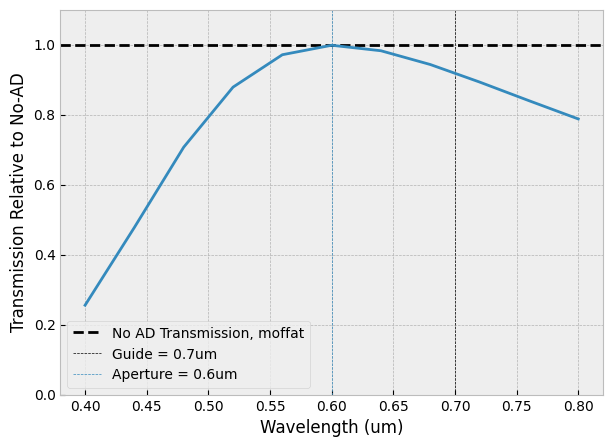

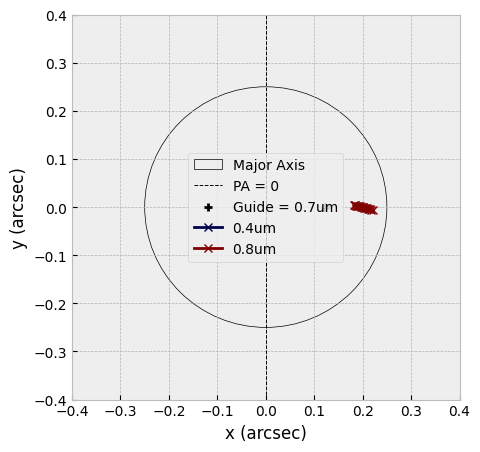

In [46]:
simulation.integration_plots()

And there we have a basic analysis of atmospheric dispersion for our desired instrument! As we can see, in this case there are strong differential losses at the edges of the band as you move away from the aperture centre wavelength.

## Very Basic (but quick) Analysis

The above can be condensed into one handy line with the simulation.run() function. However, it lacks alot of the customisation available! 

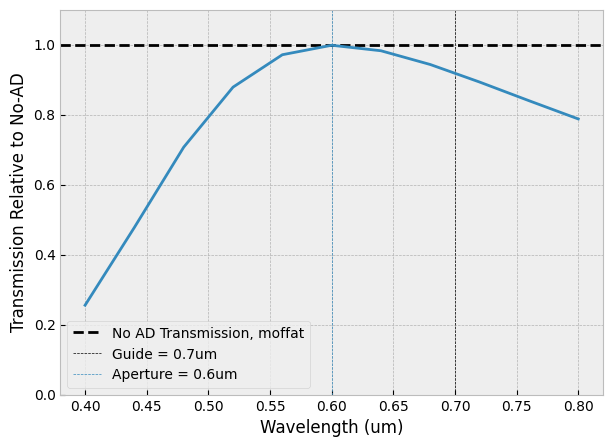

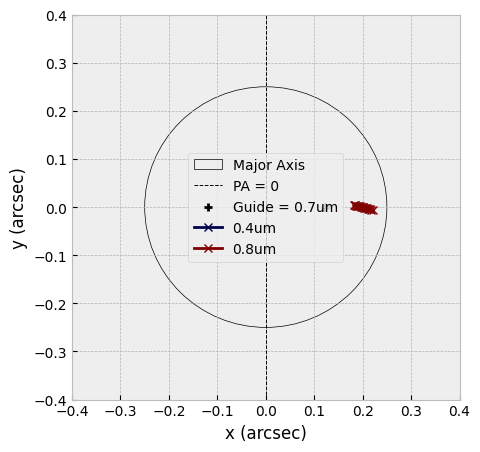

In [47]:
simulation=dispersion.sim()
simulation.run(observation_start=2,observation_end=3,declination=-30,wavelengths=np.linspace(.4,.8,11),aperture_major_axis=.5,guide_wavelength=.7,aperture_wavelength=.6)

## Optimising Guide and Aperture Wavelengths

The guide and aperture wavelengths are key values that significantly impact the resultant transmissions.

For an instrument observing in one band at an instant, The optimal choices to reduce losses in the wings and to keep overall throughput high isn't as straightforward as being halfway through an observing band - in general it is more shifted towards the blue because blue wavelengths undergo more dispersion. 

Atmosphyre has a class function that can optimise these values - however, it can take a long time if the user isn't careful!

In [54]:
simulation=dispersion.sim()
simulation.load_observation(observation_start=2,observation_end=3,declination=-30)
simulation.load_wavelengths(wavelengths=np.linspace(.4,.8,11))
simulation.load_aperture(aperture_major_axis=.5)

Optimal Metrics:
Min Transmission = 44%
Max Transmission = 99%
Throughput = 76%


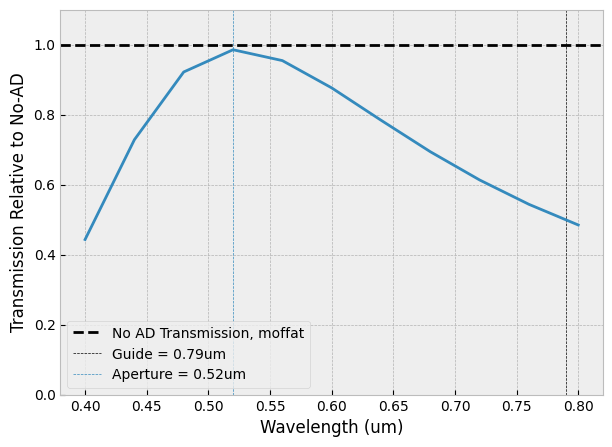

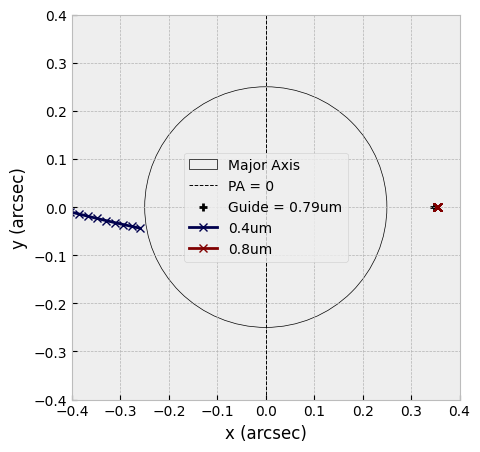

In [62]:
simulation.optimise_integration(np.arange(0.4,0.8,0.01),np.arange(0.4,0.8,0.01),guide_aperture="independent")
simulation.integration_plots()

This example took around 2 minutes. It can be sped up by reducing the number of input wavelengths and by reducing the options that are available for the guide and aperture. A trick is to force the two wavelengths to be the same by changing the guide_aperture term to "equal":

Optimal Metrics:
Min Transmission = 43%
Max Transmission = 100%
Throughput = 76%


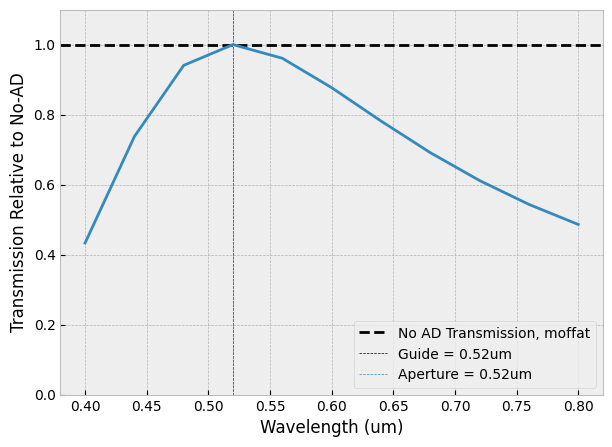

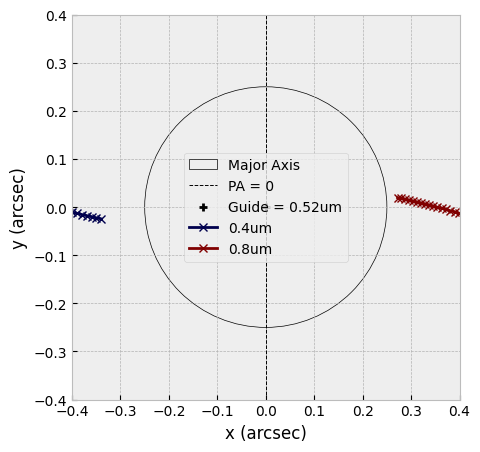

In [63]:
simulation.optimise_integration(np.arange(0.4,0.8,0.01),np.arange(0.4,0.8,0.01),guide_aperture="equal")
simulation.integration_plots()

This by contrast took 3 seconds to run. The transmissions are roughly similar in these two examples, and this is because the guide wavelength doesn't impact much in most cases (particularly observations with just one observing band at an instant) - but in certain setups the guide can be very important...

Some instruments observe in multiple observing bands with seperate apertures simeultaneously; in this case, the guide wavelength is shared, but there are seperate aperture wavelengths. Finding the optimal values for this case isn't as straightforward, and can be seen in the MOSAIC example page.